# Problem statement
Example 6.6 - Reinforcement Learning: An Introduction, Sutton and Barto, Second Edition

In this notebook, we calculate the optimal policy using the off-policy Temporal Difference method (Q-learning) for the cliff walking problem.

In [1]:
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 

from envs.cliff_walking import CliffWalkingEnv
from utils import plotting
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
def epsilon_greedy_policy(action_values, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on the given action_values and epsilon
    
    @action_values: maps from state -> action-values
    @epsilon: the probability to select a random action
    @num_actions: number of actions in the environment
    
    Returns:
        A function that takes the observation (state) as an argument and returns
        the probabilities for each action
    
    """
    def policy_fn(observation):
        actions_prob = np.ones(num_actions, dtype=float) * epsilon / num_actions
        best_action = np.argmax(action_values[observation])
        actions_prob[best_action] += (1.0 - epsilon)
        return actions_prob
    return policy_fn

In [4]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    TD(0) off-policy control (Q-learning) to find the optimal policy
    
    @env: OpenAI environment
    @num_episodes: Number of episodes to sample
    @discount_factor: Gamma discount factor
    @alpha: TD learning rate
    @epsilon: the probability to select a random action
    
    Returns:
        (action_values, policy) tuple
    """
    # The final action-value function
    # maps state -> (action -> action-value)
    action_values = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of episodes length and rewards
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Get the epsilon-greedy policy to follow
    policy = epsilon_greedy_policy(action_values, epsilon, env.action_space.n)
    
    
    for i_episode in range(num_episodes):
        if (i_episode + 1) % 10 == 0:
            print(f"\rEpisode {i_episode + 1}/{num_episodes}.", end="")
            sys.stdout.flush()
        
        # Reset the environment
        state = env.reset()
        
        for t in itertools.count():
            # Note that we don't update next action at the end of the step in Q-learning as opposed to SARSA since we have an
            # off-policy method here
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            # Note that we use best next action in Q-learning as opposed to next action in SARSA
            best_next_action = np.argmax(action_values[next_state])    
            td_target = reward + discount_factor * action_values[next_state][best_next_action]
            action_values[state][action] += alpha * (td_target - action_values[state][action])
                
            if done:
                break
                
            state = next_state
                
    return action_values, stats

In [5]:
action_values, stats = q_learning(env, 500)

Episode 500/500.

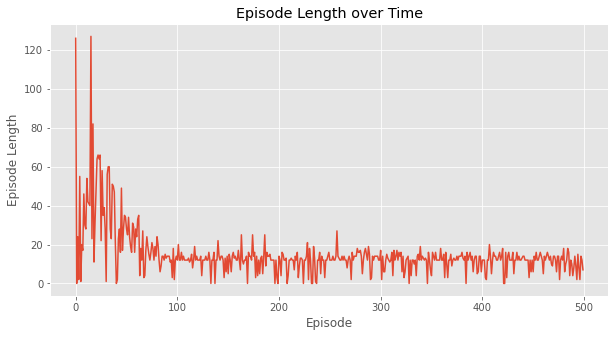

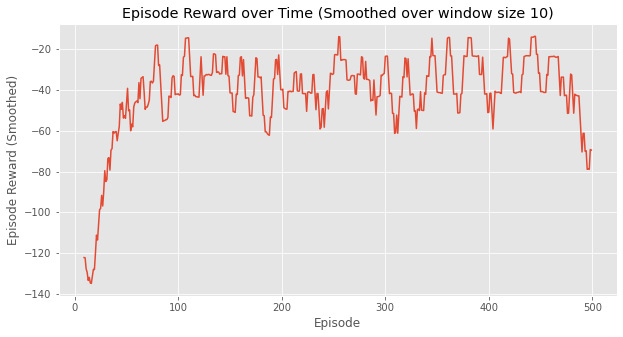

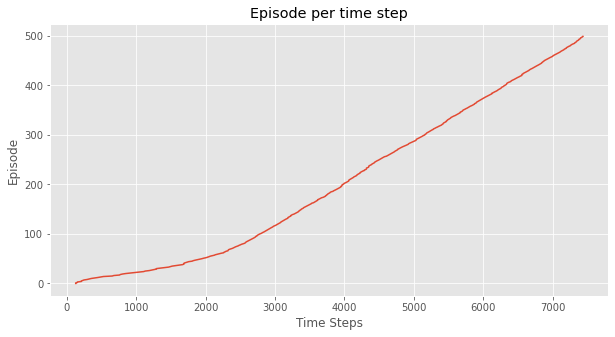

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)